In [1]:
setwd('/import/jliu/data2/')

In [2]:
load('./data.new.rda')

In [3]:
ls()

[1] "nn"

In [4]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [5]:
nn = nn %>%  filter(Type == 1)

In [6]:
expr = nn[,-1]

In [7]:
group1 = read.csv('./resultstrain/resultstrain.k=2.consensusClass.csv',header =F)
group1$V2 = paste0('subtype',group1$V2)
colnames(group1) = c('V1','V3')
cliinfo = group1
table(cliinfo$V3)
group = data.frame(sample = cliinfo$V1,
                  group = cliinfo$V3)
rownames(group) = group[,1]
library(dplyr)
group = group %>%tibble::remove_rownames() %>%   tibble::column_to_rownames(.,'sample')


subtype1 subtype2 
      32       11 

In [8]:
group.all1 = group

In [9]:
fpkm = expr %>%  t() %>% as.data.frame()

In [10]:
fpkm = fpkm[,rownames(group)]

In [11]:
prot = read.table('./prot.txt')

In [12]:
fpkm = fpkm[prot$V1,] %>% na.omit()

In [13]:
dataExpr = fpkm

In [14]:
library(WGCNA)
library(reshape2)
library(stringr)
options(stringsAsFactors = FALSE)
# 打开多线程
enableWGCNAThreads()
#exprMat <- "./fpkm.txt"
type = "unsigned"
corType = "pearson"
corFnc = ifelse(corType=="pearson", cor, bicor)
maxPOutliers = ifelse(corType=="pearson",1,0.05)
robustY = ifelse(corType=="pearson",T,F)

Warning message:
"package 'WGCNA' was built under R version 4.2.3"
Loading required package: dynamicTreeCut

Warning message:
"package 'dynamicTreeCut' was built under R version 4.2.3"
Loading required package: fastcluster

Warning message:
"package 'fastcluster' was built under R version 4.2.3"

Attaching package: 'fastcluster'


The following object is masked from 'package:stats':

    hclust





Attaching package: 'WGCNA'


The following object is masked from 'package:stats':

    cor


Warning message:
"package 'reshape2' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"


Allowing parallel execution with up to 255 working processes.


In [15]:
m.mad <- apply(dataExpr,1,mad)
dataExprVar <- dataExpr[which(m.mad > 
                 max(quantile(m.mad, probs=seq(0, 1, 0.25))[2],0.01)),]

dataExpr <- as.data.frame(t(dataExprVar))
gsg = goodSamplesGenes(dataExpr, verbose = 3)

 Flagging genes and samples with too many missing values...
  ..step 1


In [16]:
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(dataExpr)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(dataExpr)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]
}


In [17]:
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)
dim(dataExpr)

[1]    43 13410

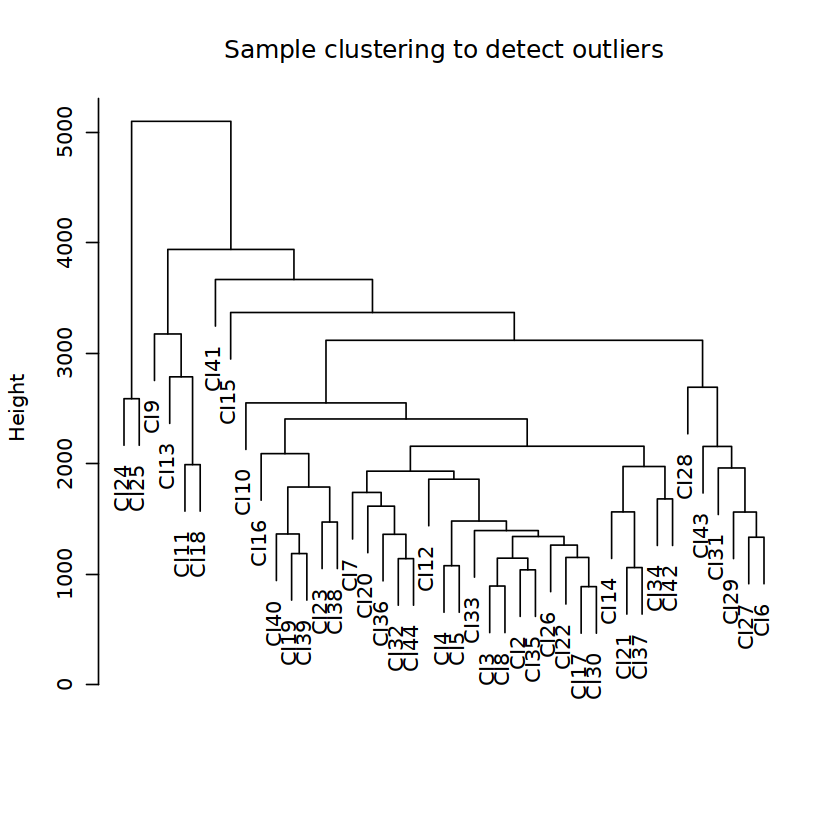

In [18]:
sampleTree = hclust(dist(dataExpr), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

In [19]:
clust = cutreeStatic(sampleTree, cutHeight = 4000, minSize = 10)
table(clust)
# clust 1 contains the samples we want to keep.
keepSamples = (clust==1)

clust
 0  1 
 2 41 

In [20]:
dataExpr = dataExpr[keepSamples, ]

In [21]:
group1 = read.csv('./resultstrain/resultstrain.k=2.consensusClass.csv',header =F)
group1$V2 = paste0('subtype',group1$V2)
colnames(group1) = c('V1','V3')
cliinfo = group1
table(cliinfo$V3)
group = data.frame(sample = cliinfo$V1,
                  group = cliinfo$V3)
rownames(group) = group[,1]


subtype1 subtype2 
      32       11 

In [22]:
group =group[rownames(dataExpr),]

In [23]:
library(dplyr)
group = group %>%tibble::remove_rownames() %>%   tibble::column_to_rownames(.,'sample')

In [24]:
powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, 
                        networkType=type, verbose=5)

pickSoftThreshold: will use block size 3336.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3336 of 13410
   ..working on genes 3337 through 6672 of 13410
   ..working on genes 6673 through 10008 of 13410
   ..working on genes 10009 through 13344 of 13410
   ..working on genes 13345 through 13410 of 13410
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.5620  1.190          0.895 3950.00  4080.000 5960.0
2      2   0.0438 -0.168          0.603 1750.00  1760.000 3580.0
3      3   0.4020 -0.700          0.724  937.00   882.000 2480.0
4      4   0.5430 -1.010          0.795  562.00   483.000 1850.0
5      5   0.5960 -1.240          0.827  364.00   282.000 1440.0
6      6   0.6240 -1.390          0.848  248.00   172.000 1150.0
7      7   0.6650 -1.480          0.880  176.00   109.000  947.0
8      8   0.6730 -1.590          0.885  129.00    70.700  790.0
9      9   0.6810 -1.670          0.892   96.70    47.500 

In [25]:
options(repr.plot.width = 9)

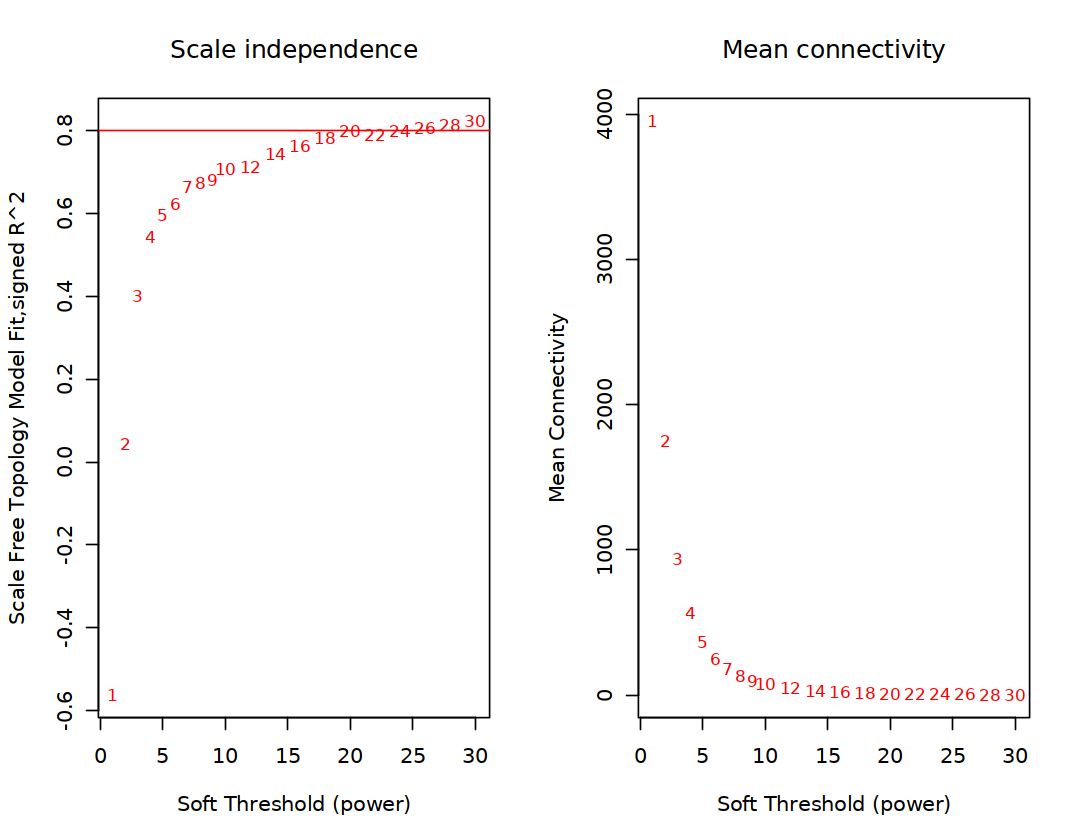

In [26]:
par(mfrow = c(1,2))
cex1 = 0.8
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# 筛选标准。R-square=0.85
abline(h=0.8,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")

In [27]:
power = sft$powerEstimate
power

[1] NA

In [28]:
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}

In [29]:
exprMat='data.txt'

In [30]:
net = blockwiseModules(dataExpr, power = power, maxBlockSize = nGenes,
                       TOMType = type, minModuleSize = 30,
                       reassignThreshold = 0, mergeCutHeight = 0.35,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs=TRUE, corType = corType, 
                       maxPOutliers=maxPOutliers, loadTOMs=TRUE,
                       saveTOMFileBase = paste0(exprMat, ".tom"),
                       verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 128 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file data.txt.tom-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 151 genes from module 1 because their KME is too low.
     ..removing 79 genes from module 2 because their KME is too low.
     ..removing 47 genes from module 3 because their KME is too low.
     ..removing 53 genes from module 4 because their KME is too low.
     ..removing 25 genes from module 5 because their KME is too low.
     ..removing 4 genes from module 6 because their KME is too low.
     ..removing 18 genes from module 7 b

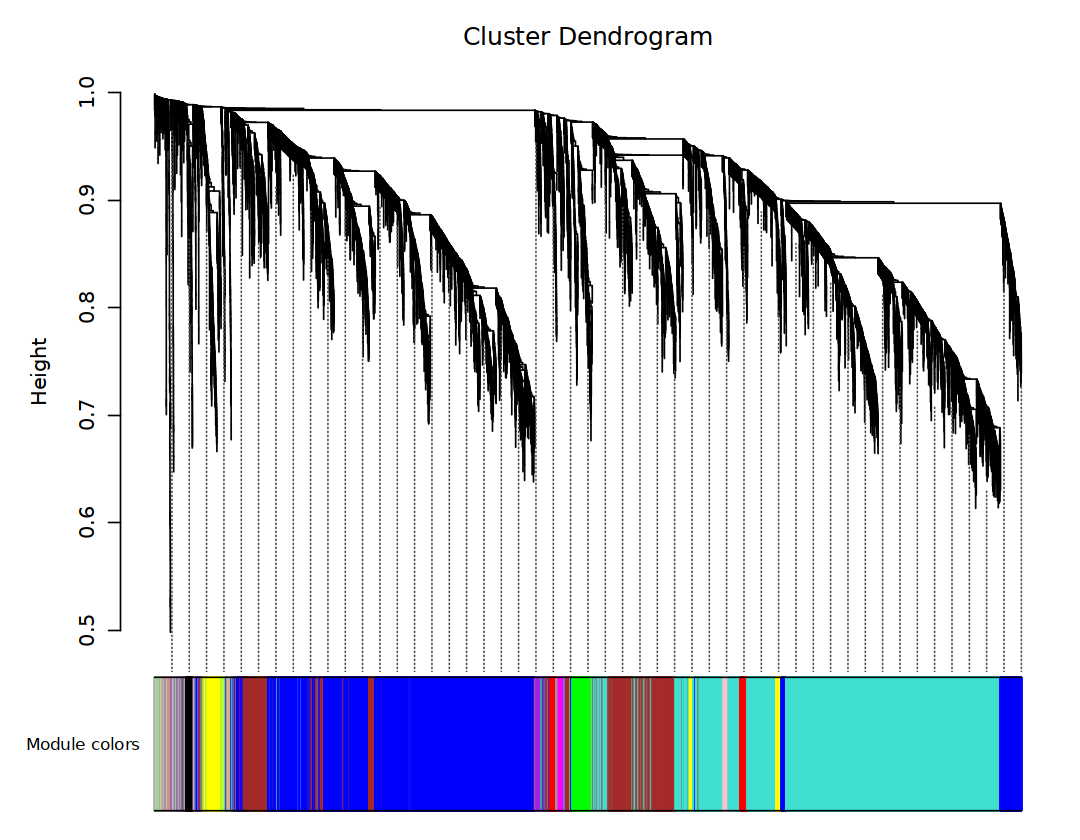

In [31]:
moduleLabels = net$colors
moduleColors = labels2colors(moduleLabels)
plotDendroAndColors(net$dendrograms[[1]], moduleColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [32]:
MEs = net$MEs
MEs_col = MEs
colnames(MEs_col) = paste0("ME", labels2colors(
  as.numeric(str_replace_all(colnames(MEs),"ME",""))))
MEs_col = orderMEs(MEs_col)

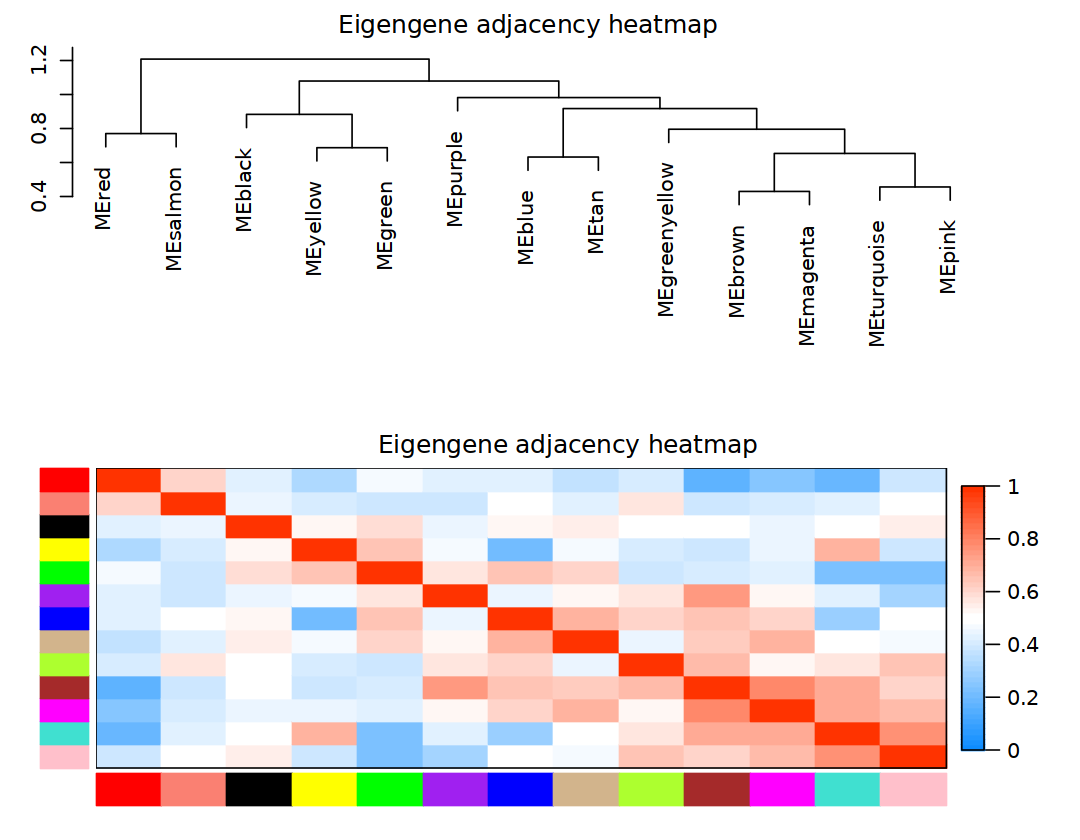

In [33]:
plotEigengeneNetworks(MEs_col, "Eigengene adjacency heatmap", 
                      marDendro = c(3,3,2,4),
                      marHeatmap = c(3,4,2,2), plotDendrograms = T, 
                      xLabelsAngle = 90)

In [34]:
TOM = TOMsimilarityFromExpr(dataExpr, power=power, corType=corType, networkType=type)

TOM calculation: adjacency..
..will use 128 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [35]:
group.all1 = group

In [36]:
group.all1  = group.all1 %>%  tibble::rownames_to_column(.,'sample')

In [37]:
group.all1$group = as.character(group.all1$group )

In [38]:
design <- model.matrix(~0 + group.all1$group)


In [39]:
dimnames(design) <- list(group.all1$sample, sort(unique(group.all1$group)))


In [40]:
design <- design[rownames(MEs_col),]

In [41]:
# 计算 pearson 相关性和显著性
modTraitCor <- cor(MEs_col, design, use = "p")
modTraitP <- corPvalueStudent(modTraitCor, dim(group.all1)[1])

In [42]:
modTraitCorP = bicorAndPvalue(MEs_col, design)
modTraitCor = modTraitCorP$bicor
modTraitP   = modTraitCorP$p

Warning message in bicor(x, y, use = use, ...):
"bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD."


In [43]:
options(repr.plot.height = 8,repr.plot.width = 7)

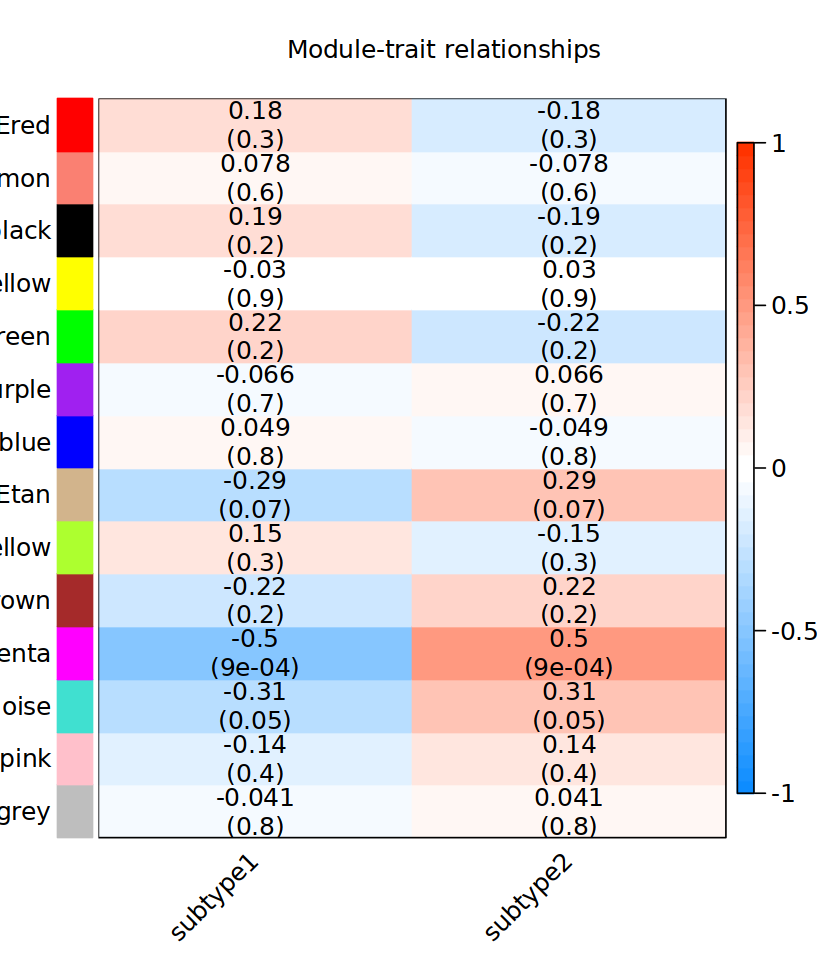

In [44]:
textMatrix <- paste0(signif(modTraitCor, 2), "\n(", signif(modTraitP, 1), ")")
dim(textMatrix) <- dim(modTraitCor)
labeledHeatmap(
  Matrix = modTraitCor,
  xLabels = colnames(design),
  yLabels = colnames(MEs_col),
  cex.lab = 1.2,
  ySymbols = colnames(MEs_col),
  colorLabels = FALSE,
  colors = blueWhiteRed(50),
  textMatrix = textMatrix,
  setStdMargins = FALSE,
  cex.text = 1.2,
  zlim = c(-1, 1),
  main = paste("Module-trait relationships")
)

In [46]:
dat = dataExpr

In [47]:
nSamples <- nrow(dat)
#计算MM值和GS值
modNames <- substring(colnames(MEs_col), 3) ##切割，从第三个字符开始保存
geneModuleMembership <- as.data.frame(cor(dat, MEs, use = "p")) #算出每个模块跟基因的Pearson相关系数矩阵
MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples)) #计算MM值对应的P值
names(geneModuleMembership) <- paste("MM", modNames, sep="")
names(MMPvalue) <- paste("p.MM", modNames, sep="")
geneTraitSignificance <- as.data.frame(cor(dat, design, use = "p")) 

In [48]:
GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))
names(geneTraitSignificance) <- paste("GS.", colnames(design), sep="")
names(GSPvalue) <- paste("p.GS.", colnames(design), sep="")

In [49]:
modNames

[1] "red"         "salmon"      "black"       "yellow"      "green"      
 [6] "purple"      "blue"        "tan"         "greenyellow" "brown"      
[11] "magenta"     "turquoise"   "pink"        "grey"

In [50]:
module <- "magenta"
column <- match(module, modNames)  ##在所有模块中匹配选择的模块，返回所在的位置
brown_moduleGenes <- names(net$colors)[which(moduleColors == module)]
MM <- abs(geneModuleMembership[brown_moduleGenes, column])
GS <- abs(geneTraitSignificance[brown_moduleGenes, 1])

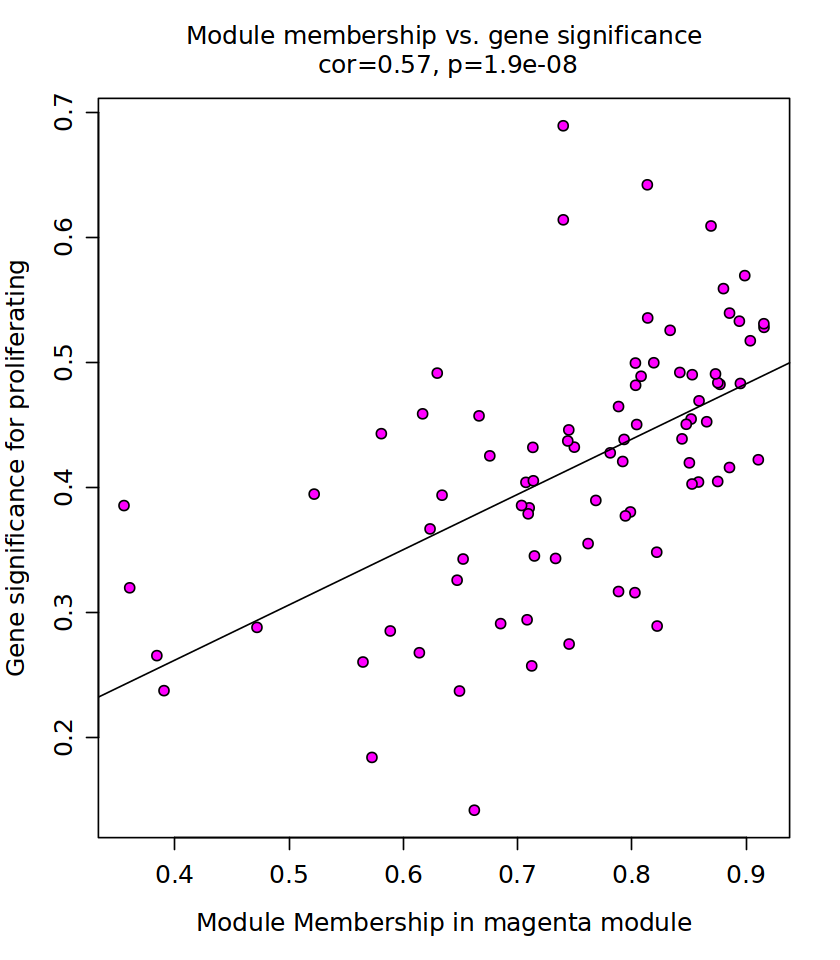

In [51]:
verboseScatterplot(
  MM, GS,
  xlab = paste("Module Membership in", module, "module"),
  ylab = "Gene significance for proliferating",
  main = paste("Module membership vs. gene significance\n"),
  abline = TRUE,
  pch = 21,
  cex.main = 1.2,
  cex.lab = 1.2,
  cex.axis = 1.2,
  col = "black",
  bg = module
)

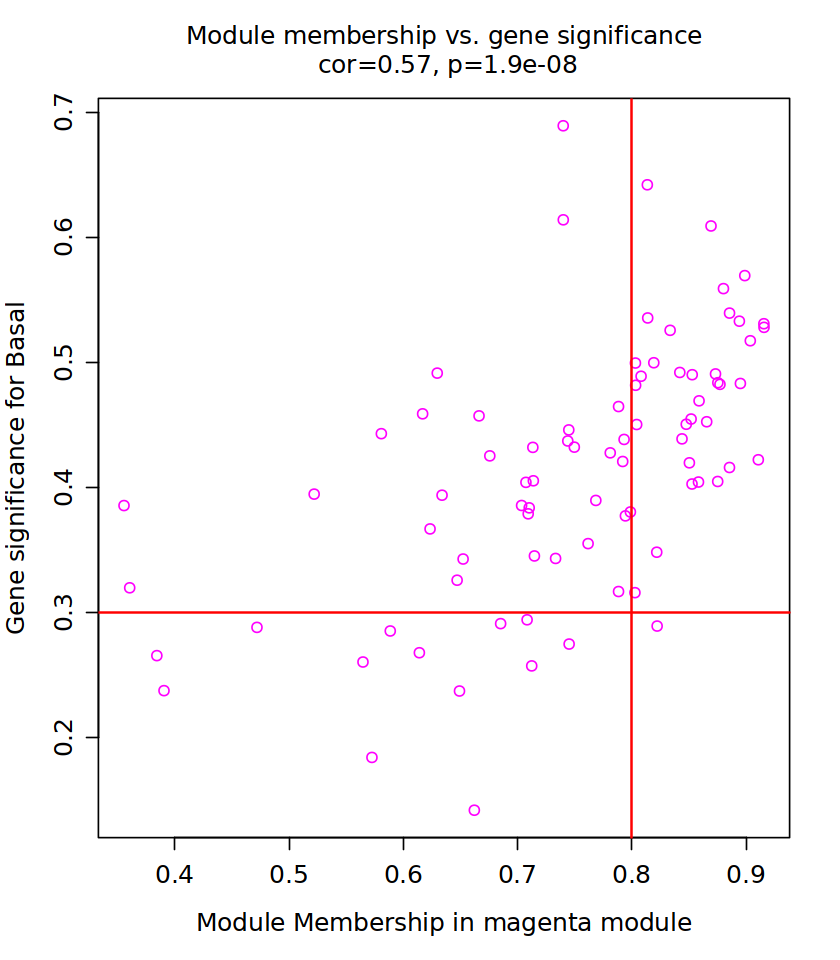

In [52]:
verboseScatterplot(MM, GS,
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for Basal",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
abline(h=0.3,v=0.8,col="red",lwd=1.5)

[1] 61

Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfil


FALSE  TRUE 
   57     4 

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


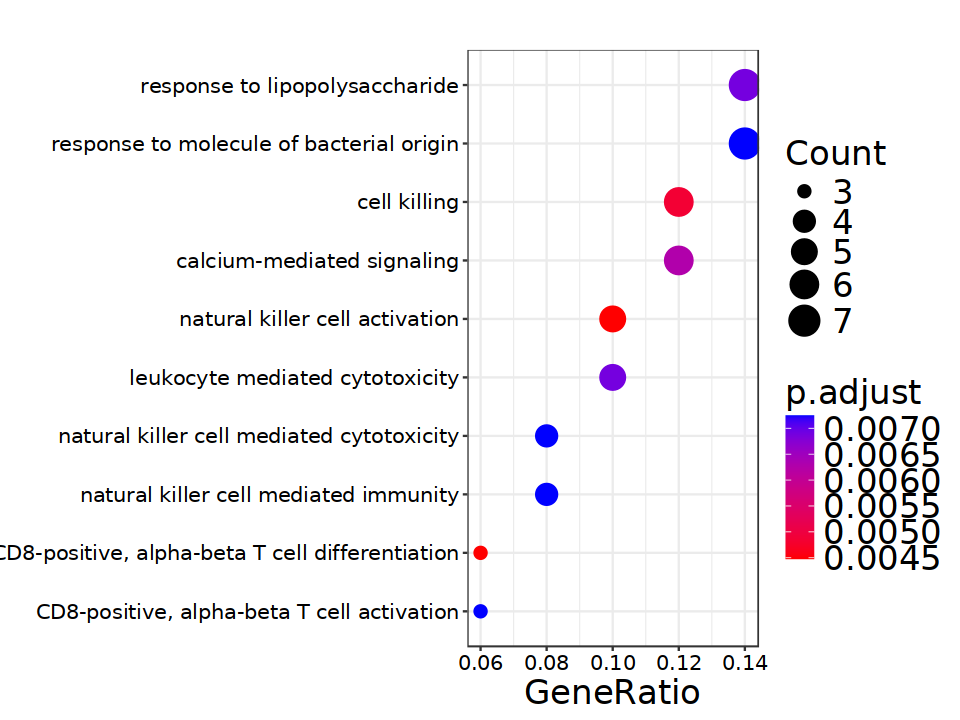

In [53]:
black_hub <- brown_moduleGenes[(GS > 0.2 & MM > 0.7)]
length(black_hub)

write.csv(black_hub,'black_hub_gene.csv')

library(clusterProfiler)
library(org.Hs.eg.db)
options(stringsAsFactors = F)
 
brown_hub_gene <- read.csv('black_hub_gene.csv',header = F)
brown_hub_gene <- brown_hub_gene[-1,]
brown_hub_gene <- brown_hub_gene[,-1]
gene=unique(brown_hub_gene)
##基因转ID
sig_DP_entrezId <- mapIds(x = org.Hs.eg.db,
                             keys = gene,
                             keytype = "SYMBOL",
                             column = "ENTREZID")

table(is.na(sig_DP_entrezId))

sig_DP_entrezId <- na.omit(sig_DP_entrezId)
go_bp <- enrichGO(gene = sig_DP_entrezId,
                      OrgDb = org.Hs.eg.db,
                      keyType = "ENTREZID",
                      ont = "BP",
                      pvalueCutoff = 0.05,
                      qvalueCutoff = 1,
                      readable = TRUE)


library(ggplot2)

options(repr.plot.width = 8,repr.plot.height = 6)

#画图
dotplot(go_bp,label_format = 100) + theme(text=element_text(size= 20 ), #change font size of all text
        axis.text =element_text(size= 20 ), #change font size of axis text
        axis.title =element_text(size= 20 ), #change font size of axis titles
        plot.title =element_text(size= 20 ), #change font size of plot title
        legend.text =element_text(size= 20 ), #change font size of legend text
        legend.title =element_text(size= 20 ))

In [54]:
options(repr.plot.width = 8,repr.plot.height = 6)

In [55]:
ek <- enrichKEGG(gene =sig_DP_entrezId , 
                   organism = "hsa",  
                   pvalueCutoff =1, 
                   qvalueCutoff = 1) 
    keggres = ek@result
    #write.csv(keggres,file = 'kegg_results.csv')

    #ggsave('KEGG_enrichment_dotplot.pdf',height = 6,width = 6)
    # KEGG2 <- pairwise_termsim(ek)
    # emapplot(KEGG2, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
    #   ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
    #                         guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
    #ggsave('KEGG_enrichment_net.pdf',height = 8,width = 8)   

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



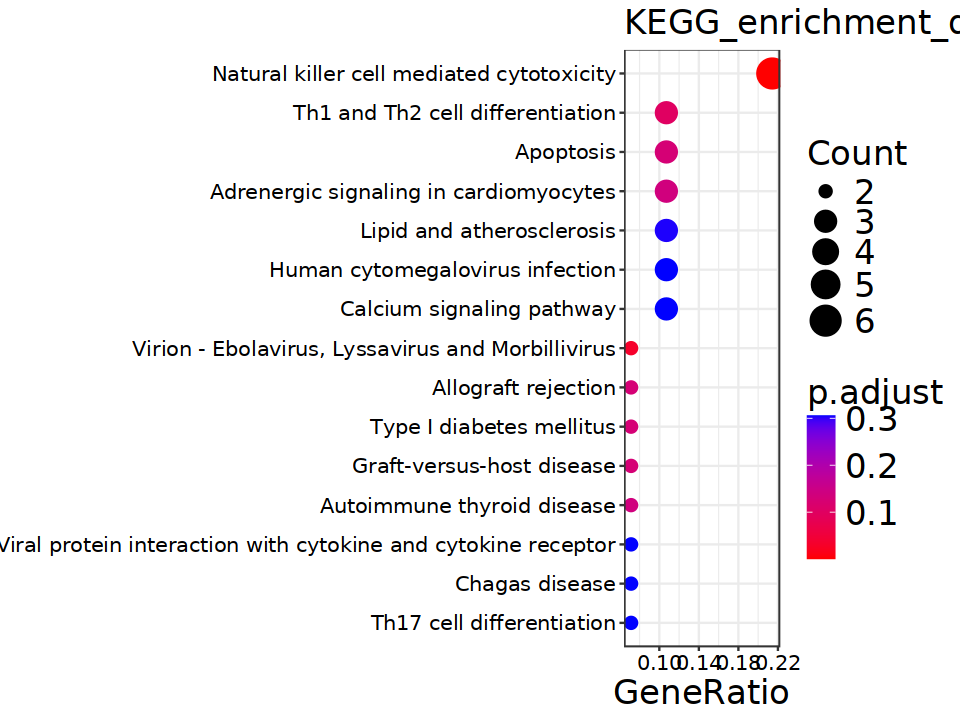

In [56]:
    enrichplot::dotplot(ek,  
            x = "GeneRatio", 
            color = "p.adjust", 
            showCategory = 15, 
            size = 'Count', label_format = 100,
            title = "KEGG_enrichment_dotplot"  
            )+ theme(text=element_text(size= 20 ), #change font size of all text
        axis.text =element_text(size= 20 ), #change font size of axis text
        axis.title =element_text(size= 20 ), #change font size of axis titles
        plot.title =element_text(size= 20 ), #change font size of plot title
        legend.text =element_text(size= 20 ), #change font size of legend text
        legend.title =element_text(size= 20 ))

In [146]:
module <- "green"
column <- match(module, modNames)  ##在所有模块中匹配选择的模块，返回所在的位置
brown_moduleGenes <- names(net$colors)[which(moduleColors == module)]
MM <- abs(geneModuleMembership[brown_moduleGenes, column])
GS <- abs(geneTraitSignificance[brown_moduleGenes, 1])

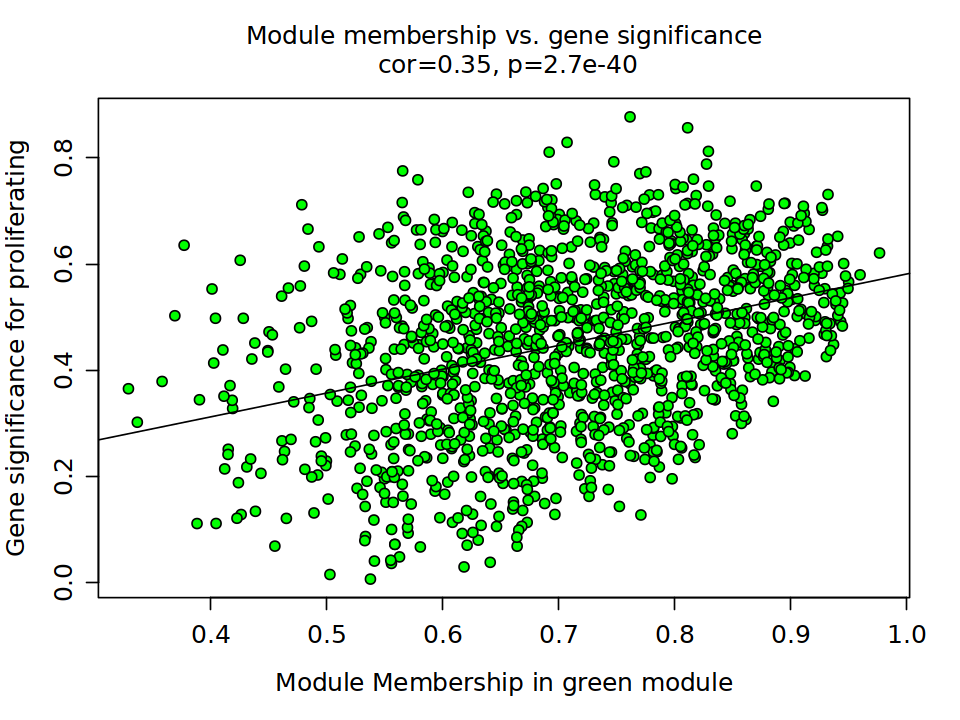

In [147]:
verboseScatterplot(
  MM, GS,
  xlab = paste("Module Membership in", module, "module"),
  ylab = "Gene significance for proliferating",
  main = paste("Module membership vs. gene significance\n"),
  abline = TRUE,
  pch = 21,
  cex.main = 1.2,
  cex.lab = 1.2,
  cex.axis = 1.2,
  col = "black",
  bg = module
)

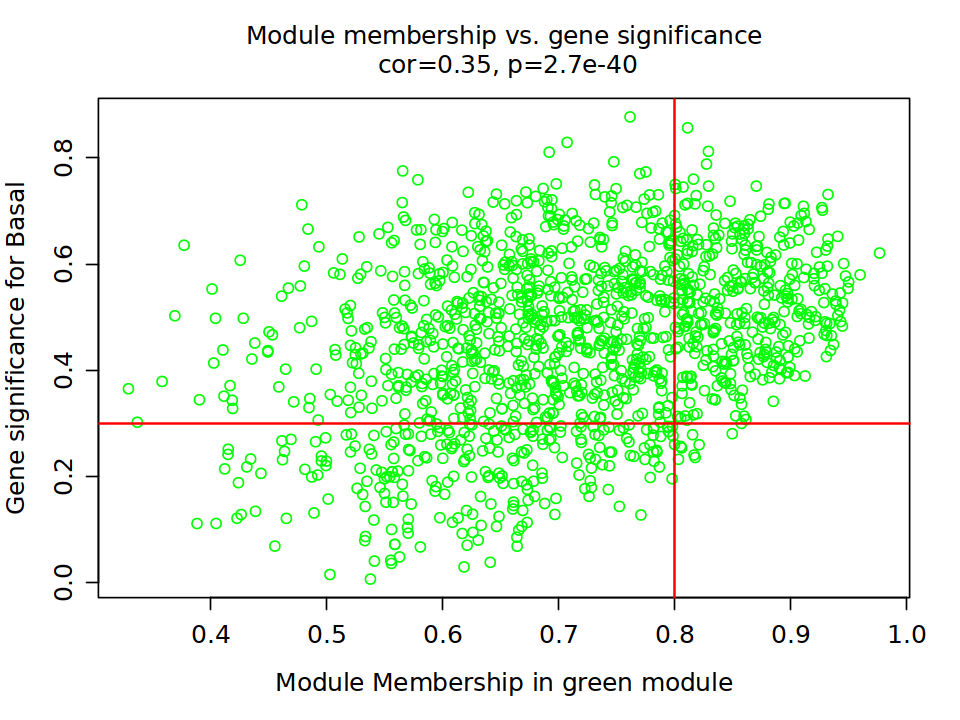

In [148]:
verboseScatterplot(MM, GS,
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for Basal",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
abline(h=0.3,v=0.8,col="red",lwd=1.5)

[1] 710

'select()' returned 1:1 mapping between keys and columns




FALSE 
  710 

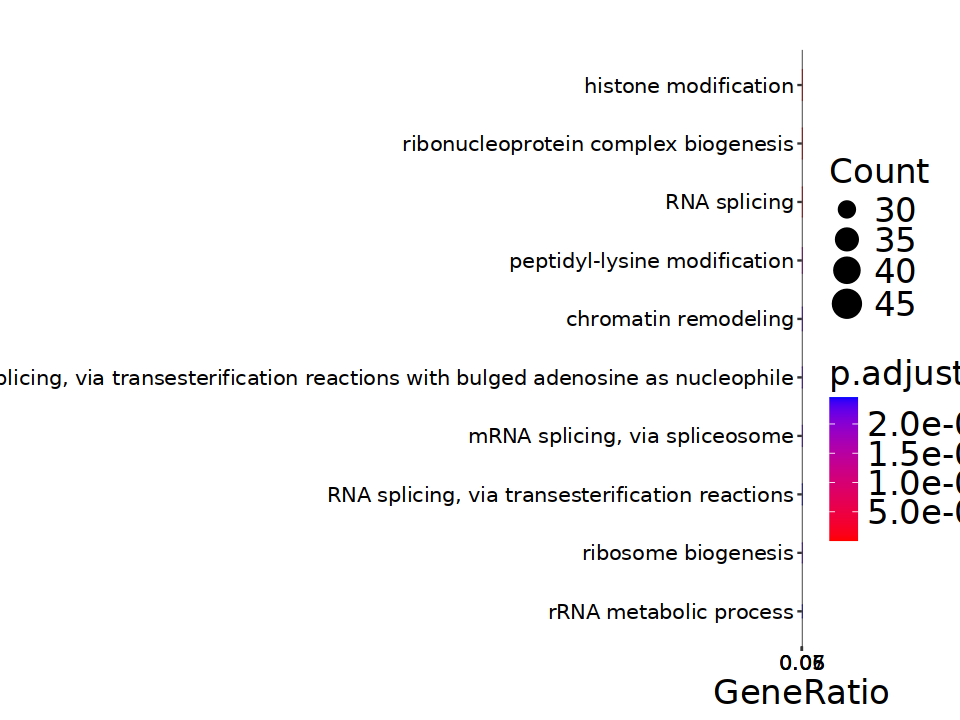

In [149]:
black_hub <- brown_moduleGenes[(GS > 0.2 & MM > 0.7)]
length(black_hub)

write.csv(black_hub,'green_hub_gene.csv')

library(clusterProfiler)
library(org.Hs.eg.db)
options(stringsAsFactors = F)
 
brown_hub_gene <- read.csv('green_hub_gene.csv',header = F)
brown_hub_gene <- brown_hub_gene[-1,]
brown_hub_gene <- brown_hub_gene[,-1]
gene=unique(brown_hub_gene)
##基因转ID
sig_DP_entrezId <- mapIds(x = org.Hs.eg.db,
                             keys = gene,
                             keytype = "SYMBOL",
                             column = "ENTREZID")

table(is.na(sig_DP_entrezId))

sig_DP_entrezId <- na.omit(sig_DP_entrezId)
go_bp <- enrichGO(gene = sig_DP_entrezId,
                      OrgDb = org.Hs.eg.db,
                      keyType = "ENTREZID",
                      ont = "BP",
                      pvalueCutoff = 0.05,
                      qvalueCutoff = 1,
                      readable = TRUE)




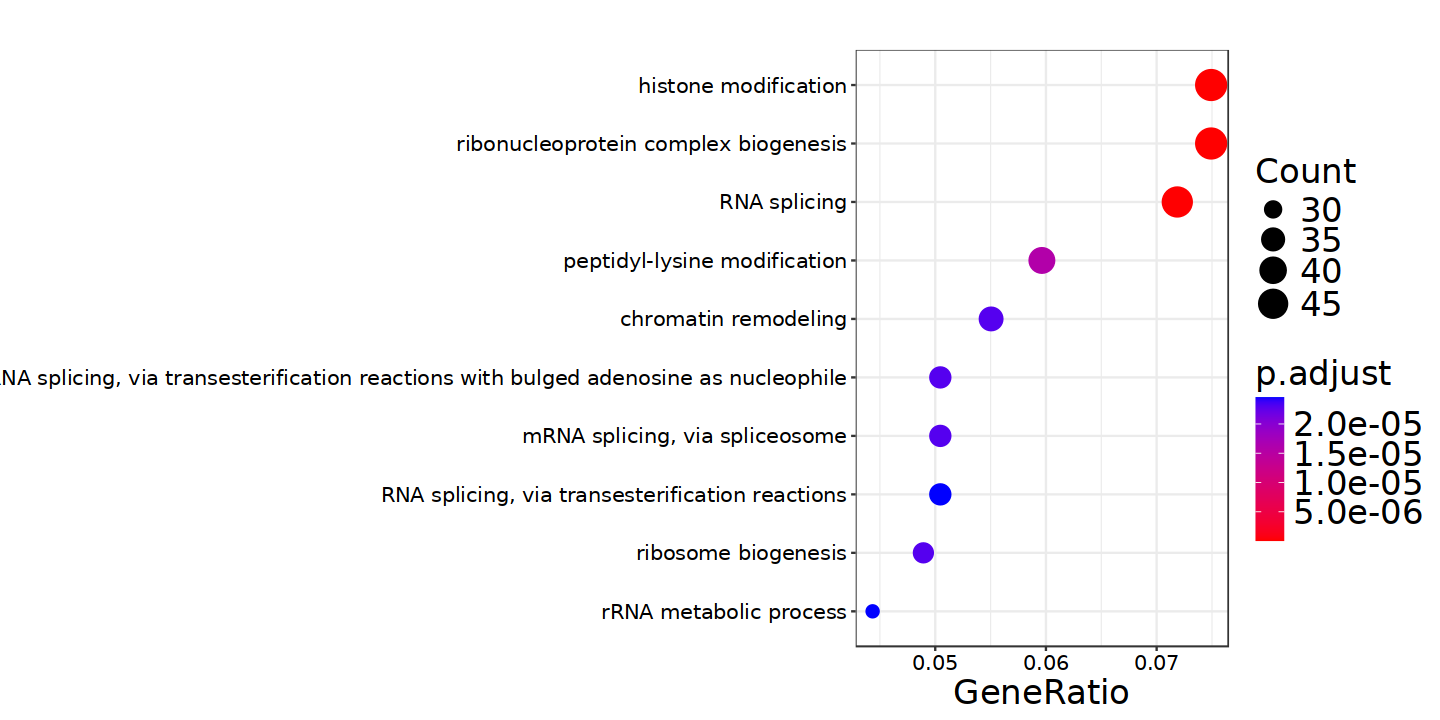

In [152]:
library(ggplot2)

options(repr.plot.width = 12,repr.plot.height = 6)

#画图
dotplot(go_bp,label_format = 100) + theme(text=element_text(size= 20 ), #change font size of all text
        axis.text =element_text(size= 20 ), #change font size of axis text
        axis.title =element_text(size= 20 ), #change font size of axis titles
        plot.title =element_text(size= 20 ), #change font size of plot title
        legend.text =element_text(size= 20 ), #change font size of legend text
        legend.title =element_text(size= 20 ))

In [153]:
ek <- enrichKEGG(gene =sig_DP_entrezId , 
                   organism = "hsa",  
                   pvalueCutoff =1, 
                   qvalueCutoff = 1) 
    keggres = ek@result

In [157]:
options(repr.plot.width = 8,repr.plot.height = 6)

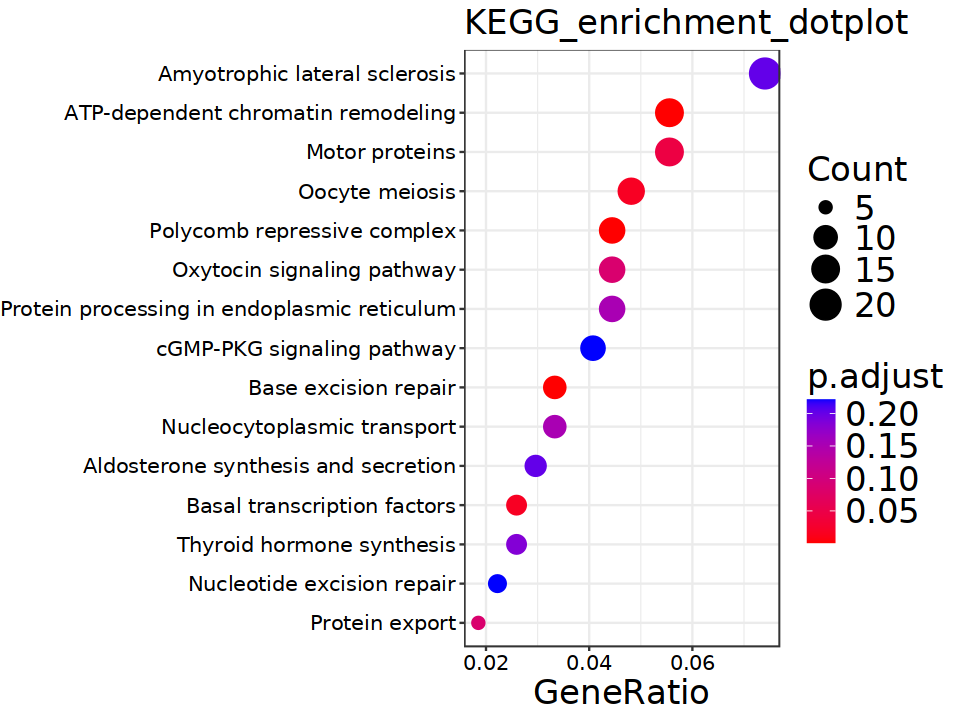

In [158]:
    enrichplot::dotplot(ek,  
            x = "GeneRatio", 
            color = "p.adjust", 
            showCategory = 15, 
            size = 'Count', label_format = 100,
            title = "KEGG_enrichment_dotplot"  
            )+ theme(text=element_text(size= 20 ), #change font size of all text
        axis.text =element_text(size= 20 ), #change font size of axis text
        axis.title =element_text(size= 20 ), #change font size of axis titles
        plot.title =element_text(size= 20 ), #change font size of plot title
        legend.text =element_text(size= 20 ), #change font size of legend text
        legend.title =element_text(size= 20 ))